# training-E.ipynb
1. This code is intended for training, validating, and testing 1D-CNN model only
2. Prepared data is raw ECG data from MIT-BIH and additional ECG data from .bin format
3. There are 4 classes/labels: N, V, S, and F

## **LIBRARY IMPORTS**

In [2]:
# Import Libraries
import cudf
import os
import joblib
import pywt
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb  # For reading MIT-BIH data
import keras_tuner as kt
import seaborn as sns
import tensorflow as tf
import neurokit2 as nk

# Scikit-learn and Imbalanced-learn imports
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import entropy
from collections import Counter
from scipy.signal import find_peaks, resample, butter, filtfilt, iirnotch, spectrogram
from sklearn.utils import class_weight
from glob import glob

# Model imports
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Dropout, Add, GlobalAveragePooling1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from cuml.ensemble import RandomForestClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.utils.class_weight import compute_class_weight

# Additional setups
# Checking cUML
print(cudf.Series([1, 2, 3]))

# Setting TensorFlow flags
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Checking GPU
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"TensorFlow has detected {len(gpu_devices)} GPU(s):")
    for device in gpu_devices:
        print(f"- {device}")
else:
    print("TensorFlow did not detect any GPUs. Training will run on the CPU.")


2025-09-01 14:37:28.995888: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-01 14:37:30.162974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756712250.473298     480 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756712250.529117     480 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756712251.331881     480 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

0    1
1    2
2    3
dtype: int64
TensorFlow has detected 1 GPU(s):
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## **DATA PREPARATION**

### DATA PREPARATION FUNCTIONS
1. prepare_cnn_data
* Purpose: This function is the core processor for the MIT-BIH Arrhythmia Database. It takes the raw ECG signals and their corresponding annotations to generate labeled, windowed segments of the signal, which serve as the direct input for the 1D-CNN.
* Key Steps:
    1) Signal Denoising: It first applies the preprocess_signal function to remove noise like baseline wander and powerline interference.
    2) Resampling: The signal's frequency is resampled from the original 360 Hz to a target of 500 Hz to standardize the data.
    3) R-Peak Alignment: It adjusts the locations of the R-peaks (the most prominent part of a heartbeat) to match the new, higher sampling rate.
    4) Windowing: For each annotated heartbeat, it extracts a fixed-size window of the signal (400 samples, or 0.8 seconds). The R-peak is used as the central anchor point for this window.
    5) Labeling: Each extracted window is assigned a numerical label based on the AAMI class mapping (e.g., 'N' for Normal becomes 0).
* Output: The function returns two arrays: one containing the raw signal windows (the data, or X) and another containing their corresponding numerical labels (the targets, or y).

2. prepare_cnn_data_from_bin
* Purpose: This function is designed to process ECG data from custom binary (.bin) files. It mirrors the functionality of prepare_cnn_data but is adapted for datasets that do not have pre-existing annotation files like the MIT-BIH database.
* Key Steps:
    1) Signal Denoising: Just like the previous function, it cleans the raw signal to ensure quality.
    2) R-Peak Detection: Since no annotation file is available, it uses the detect_r_peaks_robust function to automatically identify the R-peak locations in the signal.
    3) Windowing: It segments the signal into windows around each detected R-peak.
    4) Uniform Labeling: Unlike the MIT-BIH function, all windows extracted from a single .bin file are assigned the same label, which is provided as an argument to the function (e.g., all beats from ecg_normal.bin are labeled as 0).
* Output: It returns arrays of raw signal windows and their corresponding labels, ready to be used as a final testing set.
3. Database: MIT-BIH Arrhythmia Database & additional ECG data with a format of .bin files and from heartbeat simulator
4. Preparation: Raw data for 1D-CNN

In [3]:
# --- CONFIGURATION ---
# AAMI Class Mapping
label_map = {
    'N': 0, '.': 0, 'L': 0, 'R': 0, 'e': 0, 'j': 0,  # Class 0: Normal Beats (N)
    'V': 1, 'E': 1,                                  # Class 1: Ventricular Ectopic (VEB)
    'S': 2, 'A': 2, 'a': 2, 'J': 2,                  # Class 2: Supraventricular Ectopic (SVEB)
    'F': 3                                           # Class 3: Fusion Beat (F)
}

# Reverse map for plotting labels
class_names_map = {
    0: 'Normal (N)',
    1: 'Ventricular (V)',
    2: 'Supraventricular (S)',
    3: 'Fusion (F)'
}
DB_PATH_MIT = '../data/raw/MIT-BIH/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/'
FS_MIT = 360
FS_TARGET = 500
WINDOW_SIZE = int(FS_TARGET * 0.8)  # 400 samples -> 0.8s * 500Hz

# Split MIT-BIH records into training and testing sets to prevent patient data leakage
RECORDS_TRAIN = ['101', '106', '108', '109', '112', '114', '115', '116', '118', '119',
                 '122', '124', '201', '203', '205', '207', '208', '209', '215', '220',
                 '223', '230'] # DS1
RECORDS_TEST = ['100', '103', '105', '111', '113', '117', '121', '123', '200', '202',
                '210', '212', '213', '214', '219', '221', '222', '228', '231', '232',
                '233', '234'] # DS2

custom_file_paths = {
    'Arrhythmia': '../data/raw/Arrhythmia/ECG_WAVE.bin',
    'Normal': '../data/raw/Normal/ecg_normal.bin'
}
custom_file_labels = {'Arrhythmia': 2, 'Normal': 0} # SVEB and Normal

# Define the output directory
output_dir_prepare_data = '../data/processed'
os.makedirs(output_dir_prepare_data, exist_ok=True)

# --- PREPROCESSING & UTILITIES ---
def preprocess_signal(signal, fs):
    """Applies a multi-stage denoising pipeline to a raw ECG signal."""
    signal = np.array(signal)
    nyq = 0.5 * fs
    # High-pass filter to remove baseline wander
    low_cutoff = 0.6
    b, a = butter(2, low_cutoff / nyq, btype='high')
    signal_bw_removed = filtfilt(b, a, signal)
    # Notch filter to remove powerline interference
    powerline_freq = 50
    # The quality factor Q is the center frequency divided by the bandwidth.
    # A higher Q means a narrower notch.
    b, a = iirnotch(powerline_freq, Q=30, fs=fs)
    signal_pl_removed = filtfilt(b, a, signal_bw_removed)
    # Low-pass filter to remove high-frequency noise
    high_cutoff = 100
    b, a = butter(4, high_cutoff / nyq, btype='low')
    cleaned_signal = filtfilt(b, a, signal_pl_removed)
    return cleaned_signal

def visualize_preprocessing_result(raw_signal, fs, record_name=""):
    """
    Applies preprocessing and plots the raw vs. cleaned signal for comparison.
    """
    print(f"Visualizing preprocessing for record: {record_name} (first 10 seconds)...")
    
    duration_in_seconds = 10
    snippet_length = int(duration_in_seconds * fs)
    raw_snippet = raw_signal[:snippet_length]

    cleaned_snippet = preprocess_signal(raw_snippet, fs=fs)

    time_axis = np.arange(len(raw_snippet)) / fs

    plt.figure(figsize=(15, 6))
    plt.plot(time_axis, raw_snippet, label='Raw Signal', color='blue', alpha=0.7)
    plt.plot(time_axis, cleaned_snippet, label='Cleaned Signal', color='red', linewidth=1.5)
    plt.title(f'ECG Signal Preprocessing Result for Record {record_name}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (mV)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# --- DATA LOADING UTILITIES ---
def load_mitbih_records(db_path, record_names):
    """
    Loads raw ECG signals (MLII lead only) and their annotations.
    """
    signals, all_annotations = [], []
    print(f"Loading MIT-BIH records (MLII lead only): {', '.join(record_names)}...")
    
    for rec_name in record_names:
        record_path = os.path.join(db_path, rec_name)
        try:
            # Read the record, but only channel 0 (usually MLII)
            record = wfdb.rdrecord(record_path, channels=[0])
            
            # Append the signal from the first channel
            signals.append(record.p_signal.flatten())
            
            # Read the annotation
            annotation = wfdb.rdann(record_path, 'atr')
            all_annotations.append(annotation)
            
        except Exception as e:
            print(f"Error processing record {rec_name}: {e}")
            
    print("Loading complete.")
    return signals, all_annotations

def load_ecg_from_bin(file_path, dtype=np.int16):
    """Loading raw ECG signals from binary files."""
    try:
        signal = np.fromfile(file_path, dtype=dtype)
        print(f"Completed reading {len(signal)} samples from {file_path}")
        return signal
    except IOError as e:
        print(f"An error has occurred while reading: {e}")
        return None

def detect_r_peaks_robust(signal, fs):
    """Detects R-peaks using a robust algorithm from NeuroKit2."""
    try:
        _, rpeaks_dict = nk.ecg_peaks(signal, sampling_rate=fs)
        r_peaks = rpeaks_dict['ECG_R_Peaks']
        return r_peaks
    except Exception as e:
        print(f"R-peak detection failed: {e}")
        return np.array([])

# --- DATA PREPARATION FUNCTIONS FOR 1D-CNN ---
def prepare_cnn_data(signals, annotations, window_size, fs=360, target_fs=500):
    """Processes single-lead MIT-BIH data to generate raw windows for 1D-CNN."""
    all_raw_windows, all_labels = [], []
    samples_before = window_size // 3
    samples_after = window_size - samples_before

    for i, raw_signal in enumerate(signals):
        ann = annotations[i]
        try:
            # Preprocess and resample the single signal
            cleaned_signal_orig_fs = preprocess_signal(raw_signal, fs=fs)
            num_samples_resampled = int(len(cleaned_signal_orig_fs) * (target_fs / fs))
            cleaned_signal = resample(cleaned_signal_orig_fs, num_samples_resampled)
            
            # Resample R-peak locations to match the new sampling rate
            r_peaks_resampled = np.round(ann.sample * (target_fs / fs)).astype(int)

            # Iterate through R-peaks to extract windows
            for j in range(1, len(r_peaks_resampled) - 1):
                r_peak_loc = r_peaks_resampled[j]
                symbol = ann.symbol[j]
                if symbol in label_map:
                    start, end = r_peak_loc - samples_before, r_peak_loc + samples_after
                    if start >= 0 and end < len(cleaned_signal):
                        window = cleaned_signal[start:end]
                        all_raw_windows.append(np.expand_dims(window, axis=-1))
                        all_labels.append(label_map[symbol])
        except Exception as e:
            print(f"Could not process record {ann.record_name}: {e}")
            
    return np.array(all_raw_windows), np.array(all_labels)

def prepare_cnn_data_from_bin(signal, r_peaks, window_size, label, target_fs=500):
    """Processes a single-lead .bin file to generate raw windows for 1D-CNN."""
    all_raw_windows, all_labels = [], []
    samples_before = window_size // 3
    samples_after = window_size - samples_before
    cleaned_signal = preprocess_signal(signal, fs=target_fs)

    for j in range(1, len(r_peaks) - 1):
        r_peak_loc = r_peaks[j]
        start, end = r_peak_loc - samples_before, r_peak_loc + samples_after
        if start >= 0 and end < len(cleaned_signal):
            window = cleaned_signal[start:end]
            all_raw_windows.append(np.expand_dims(window, axis=-1))
            all_labels.append(label)
            
    return np.array(all_raw_windows), np.array(all_labels)

### DATA PREPARATION EXECUTION

--- [Step 1] Processing Single-Lead MIT-BIH Data ---
Loading MIT-BIH records (MLII lead only): 101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230...
Loading complete.
Visualizing preprocessing for record: 101 (first 10 seconds)...


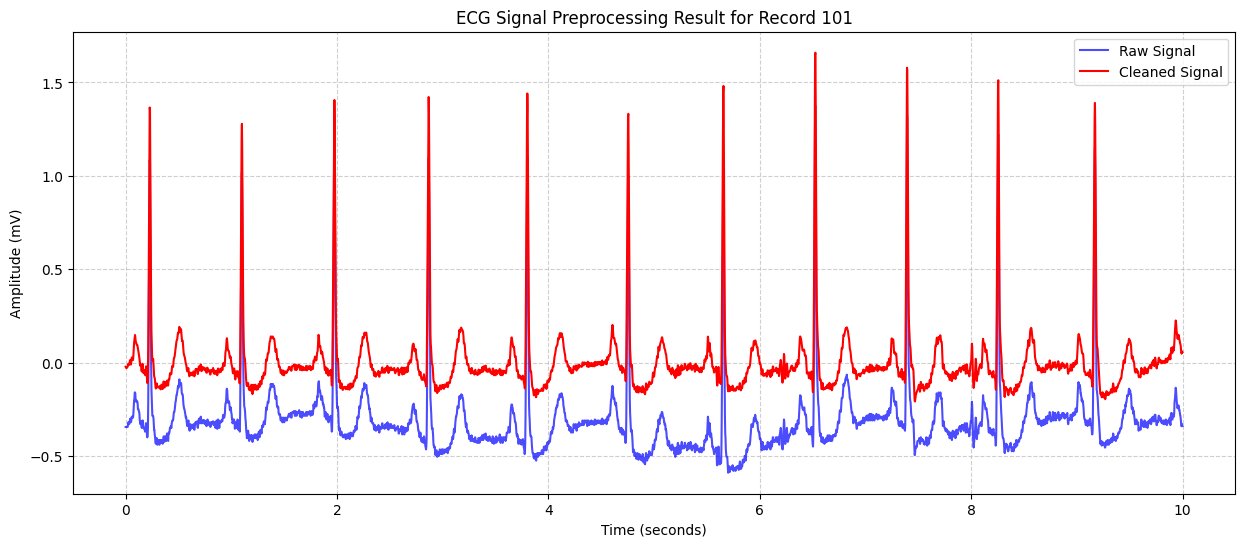

NameError: name 'prepare_features_and_raw_data' is not defined

In [4]:
# --- [5] MAIN EXECUTION SCRIPT ---
if __name__ == '__main__':
    # --- [Step 1] Process MIT-BIH Data ---
    print("--- [Step 1] Processing Single-Lead MIT-BIH Data ---")
    
    # Load raw signals and annotations for training and testing sets
    train_signals, train_anns = load_mitbih_records(DB_PATH_MIT, RECORDS_TRAIN)
    test_signals, test_anns = load_mitbih_records(DB_PATH_MIT, RECORDS_TEST)

    # Visualize preprocessing on the first training signal
    if train_signals:
        visualize_preprocessing_result(train_signals[0], fs=FS_MIT, record_name=RECORDS_TRAIN[0])

    # Prepare raw windowed data for the CNN from MIT-BIH records
    X_train_raw_base, y_train = prepare_cnn_data(
        train_signals, train_anns, WINDOW_SIZE, fs=FS_MIT, target_fs=FS_TARGET
    )
    X_test_raw_mit, y_test_mitbih = prepare_cnn_data(
        test_signals, test_anns, WINDOW_SIZE, fs=FS_MIT, target_fs=FS_TARGET
    )

    # --- [Step 2] Process Single-Lead Custom .bin Data for TESTING ---
    print("\n--- [Step 2] Processing Single-Lead Custom Data for Testing ---")
    X_test_custom_raw_list, y_test_custom_list = [], []
    for name, path in custom_file_paths.items():
        signal = load_ecg_from_bin(path)
        if signal is not None:
            # Note: Assuming custom .bin files are already at the target frequency (FS_TARGET)
            r_peaks = detect_r_peaks_robust(signal, fs=FS_TARGET)
            if r_peaks.size > 2:
                raw_single, y_single = prepare_cnn_data_from_bin(
                    signal, r_peaks, WINDOW_SIZE, custom_file_labels[name], target_fs=FS_TARGET
                )
                X_test_custom_raw_list.append(raw_single)
                y_test_custom_list.append(y_single)
            
    if X_test_custom_raw_list:
        X_test_custom_raw = np.vstack(X_test_custom_raw_list)
        y_test_custom = np.concatenate(y_test_custom_list)
    else:
        X_test_custom_raw, y_test_custom = np.array([]), np.array([])

    # --- [Step 3] Combine Test Datasets ---
    print("\n--- [Step 3] Combining Test Datasets ---")
    X_test_final = np.concatenate((X_test_raw_mit, X_test_custom_raw), axis=0)
    y_test_final = np.concatenate((y_test_mitbih, y_test_custom), axis=0)
    
    print(f"Final Test Data Shapes -> Raw: {X_test_final.shape}, Labels: {y_test_final.shape}")

    # --- [Step 4] Splitting Training Data for Validation and Resampling ---
    print("\n--- [Step 4] Splitting and Resampling Training Data ---")
    X_train, X_val, y_train_fold, y_val_fold = train_test_split(
        X_train_raw_base, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    print("Class distribution before resampling:", Counter(y_train_fold))
    
    print("Applying SMOTEENN to raw training data...")
    # Reshape for SMOTEENN (flatten the window)
    n_samples, window_len, channels = X_train.shape
    X_train_reshaped = X_train.reshape(n_samples, -1)
    
    sampler = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_reshaped, y_train_fold)
    
    # Reshape back to 3D for the CNN
    X_train_cnn = X_train_resampled.reshape(-1, window_len, channels)
    y_train_cnn_1d = y_train_resampled
    
    print("Class distribution after sampling:", Counter(y_train_cnn_1d))

    # --- [Step 5] Final Data Preparation (One-Hot Encoding) ---
    print("\n--- [Step 5] Preparing Final Datasets for Models (One-Hot Encoding) ---")
    output_dim = len(np.unique(y_train))

    y_train_cnn = to_categorical(y_train_cnn_1d, num_classes=output_dim)
    X_val_cnn = X_val
    y_val_cnn = to_categorical(y_val_fold, num_classes=output_dim)
    X_test_cnn = X_test_final
    y_test_cnn = to_categorical(y_test_final, num_classes=output_dim)

    print("\n" + "="*60)
    print("✅ DATA PREPARATION COMPLETE ✅")
    print(f"Shapes for 1D-CNN -> Train: {X_train_cnn.shape}, Val: {X_val_cnn.shape}, Test: {X_test_cnn.shape}")
    print("="*60)

## **MACHINE LEARNING MODEL TRAINING & SAVING**

### MACHINE LEARNING MODEL FUNCTIONS
The used model is optimized 1D-CNN.

In [ ]:
def create_cnn_model(input_shape, output_dim, hp=None):
    """
    Creates and compiles an optimized 1D-CNN model.
    If 'hp' is provided, it builds a tunable model for KerasTuner.
    Otherwise, it builds a model with default hyperparameters.
    """
    # Define a default hyperparameter object if none is passed
    if hp is None:
        hp = kt.HyperParameters()
        # Set default values for when not tuning
        hp.values['conv4_filters'] = 64
        hp.values['dense_units'] = 512
        hp.values['learning_rate'] = 0.0001

    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='valid', name='conv1d_1_freezed')(inputs)
    x = MaxPooling1D(pool_size=2, name='maxpool1d_1_freezed')(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name='conv1d_2_freezed')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool1d_2_freezed')(x)
    x = Conv1D(filters=4, kernel_size=3, activation='relu', padding='same', name='conv1d_3_freezed')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool1d_3_freezed')(x)
    # ===============================================
    #           Trainable Layers
    # ===============================================
    x = Conv1D(filters=hp.values['conv4_filters'], kernel_size=3, activation='relu', padding='same', name='conv1d_4_trainable')(x)
    x = Flatten(name='flatten_layer')(x)
    x = Dense(units=hp.values['dense_units'], activation='relu', name='dense_1_trainable')(x)
    outputs = Dense(units=output_dim, activation='softmax', name='output_layer_trainable')(x)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=hp.values['learning_rate']),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(average='weighted', name='f1_score'),
            tf.keras.metrics.SpecificityAtSensitivity(0.9, name='specificity')
        ]
    )
    return model

### MACHINE LEARNING MODEL TRAINING EXECUTION
1. Targeted metrics: Precision, Recall, F1-Score, and Specificity
2. There are 3 executions: multiple models training (1D-CNN, BalancedRandomForest, and MLP), MLP model specific training, and MLP model automatic hyperparameter tuning
3. After training, all models immediately saved and exported into a certain folder

In [ ]:
# --- Ten-Fold Cross Validation for CNN model---
# Define input and output dimensions for the CNN model
# We combine the initial training and validation sets for cross-validation
X_full_train = np.concatenate((X_train_cnn, X_val_cnn), axis=0)
y_full_train_cat = np.concatenate((y_train_cnn, y_val_cnn), axis=0)
y_full_train = np.argmax(y_full_train_cat, axis=1) # Get 1D labels for splitting

input_shape_cnn = (X_full_train.shape[1], X_full_train.shape[2])
output_dim = y_full_train_cat.shape[1]
class_names = ['Normal (N)', 'Ventricular (V)', 'Supraventricular (S)', 'Fusion (F)']

# Define the output directory for saving the model
output_dir = '../models'
os.makedirs(output_dir, exist_ok=True)

# --- 10-Fold Cross-Validation ---
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store metrics for each fold
fold_accuracies = []
fold_f1_scores = []
fold_losses = []

print(f"\n{'='*20} STARTING {n_splits}-FOLD CROSS-VALIDATION {'='*20}")

for fold, (train_index, val_index) in enumerate(skf.split(X_full_train, y_full_train)):
    print(f"\n--- FOLD {fold + 1}/{n_splits} ---")

    # Split the data for the current fold
    X_train, X_val = X_full_train[train_index], X_full_train[val_index]
    y_train_cat, y_val_cat = y_full_train_cat[train_index], y_full_train_cat[val_index]
    y_train = y_full_train[train_index] # 1D labels for weight calculation

    # --- Manual Class Weights Calculation for the current fold ---
    print("Calculating class weights for the current fold...")
    n_samples = len(y_train)
    class_counts = Counter(y_train)
    n_classes = len(class_counts)
    
    manual_weights = {}
    print("Manual Calculation Breakdown:")
    for i in range(n_classes):
        n_samples_in_class = class_counts.get(i, 0) # Use .get for safety
        weight = n_samples / (n_classes * n_samples_in_class)
        manual_weights[i] = weight
        print(f"  Weight for Class {i} ({class_names[i]}): {n_samples} / ({n_classes} * {n_samples_in_class}) = {weight:.4f}")
    
    class_weights_dict = dict(manual_weights)
    print("Fold Weights:", class_weights_dict)

    # --- Model Creation (re-create model for each fold) ---
    model = create_cnn_model(input_shape_cnn, output_dim)

    # --- Model Training for the current fold ---
    print("Training...")
    history = model.fit(
        X_train, y_train_cat,
        epochs=150,
        batch_size=100,
        verbose=0, # Set to 0 to keep output clean during CV
        validation_data=(X_val, y_val_cat),
        class_weight=class_weights_dict
    )

    # --- Evaluate the fold ---
    # FIX: Unpack all returned values from model.evaluate into a list
    # The first value is always loss, the second is the first metric (accuracy)
    evaluation_results = model.evaluate(X_val, y_val_cat, verbose=0)
    loss = evaluation_results[0]
    accuracy = evaluation_results[1]
    
    # Get predictions to calculate F1-score
    y_val_pred_raw = model.predict(X_val, verbose=0)
    y_val_pred = np.argmax(y_val_pred_raw, axis=1)
    y_val_true = np.argmax(y_val_cat, axis=1)
    
    # Calculate macro F1-score, which is suitable for imbalanced classes
    f1 = f1_score(y_val_true, y_val_pred, average='macro', zero_division=0)
    
    fold_losses.append(loss)
    fold_accuracies.append(accuracy)
    fold_f1_scores.append(f1) # Append F1-score
    print(f"Fold {fold + 1} - Val Loss: {loss:.4f}, Val Accuracy: {accuracy:.4f}, Val Macro F1-Score: {f1:.4f}")

# --- Average Cross-Validation Results ---
print(f"\n{'='*20} CROSS-VALIDATION SUMMARY {'='*20}")
print(f"Average Validation Accuracy: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")
print(f"Average Validation F1-Score: {np.mean(fold_f1_scores):.4f} (+/- {np.std(fold_f1_scores):.4f})")
print(f"Average Validation Loss: {np.mean(fold_losses):.4f}")


# --- Final Model Training on ALL Data ---
print(f"\n{'='*20} TRAINING FINAL MODEL ON ALL DATA {'='*20}")
# Re-calculate weights on the full training dataset
full_train_class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_full_train), y=y_full_train)
full_train_class_weights_dict = dict(enumerate(full_train_class_weights))
print("Final Model Weights:", full_train_class_weights_dict)

final_model = create_cnn_model_optimized(input_shape_cnn, output_dim)
final_model.fit(
    X_full_train, y_full_train_cat,
    epochs=150,
    batch_size=100,
    verbose=1,
    class_weight=full_train_class_weights_dict
)

# --- Final Evaluation on the Hold-Out Test Set ---
print(f"\n{'='*20} FINAL EVALUATION ON TEST SET {'='*20}")
y_pred_raw = final_model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_raw, axis=1)
y_true = y_test_final

# --- Final Evaluation Report ---
print(f"\n{'~'*15} REPORT FOR FINAL MODEL {'~'*15}")
print("\nClassification Report:")
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
print(report)

# --- Confusion Matrix Visualization ---
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Final 1D-CNN Model', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

# --- Saving the Final Model ---
print(f"\n--- Saving final model: 1D-CNN ---")
model_path = os.path.join(output_dir, "model_1d-cnn_final.keras")
final_model.save(model_path)
print(f"✅ Final Model 1D-CNN has been saved on: {model_path}")

Calculating class weights for the current fold...
Manual Calculation Breakdown:
  Weight for Class 0 (Normal (N)): 45885 / (4 * 41254) = 0.2781
  Weight for Class 1 (Ventricular (V)): 45885 / (4 * 3410) = 3.3640
  Weight for Class 2 (Supraventricular (S)): 45885 / (4 * 849) = 13.5115
  Weight for Class 3 (Fusion (F)): 45885 / (4 * 372) = 30.8367
Fold Weights: {0: 0.27806394531439377, 1: 3.3640029325513194, 2: 13.51148409893993, 3: 30.836693548387096}

==================== CREATING 1D-CNN MODEL ====================


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 400, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1_freezed (Conv1D)       │ (None, 398, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d_1_freezed             │ (None, 199, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2_freezed (Conv1D)       │ (None, 199, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d_2_freezed             │ (None, 99, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3_freezed (Conv1D)       │ (None, 99, 4)          │           772 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d_3_freezed             │ (None, 49, 4)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4_trainable (Conv1D)     │ (None, 49, 100)        │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 4900)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1_trainable (Dense)       │ (None, 256)            │     1,254,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer_trainable (Dense)  │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,270,364 (4.85 MB)

 Trainable params: 1,270,364 (4.85 MB)

 Non-trainable params: 0 (0.00 B)


==================== TRAINING 1D-CNN MODEL ====================
Epoch 1/150


2025-08-27 22:00:36.152903: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_676', 4 bytes spill stores, 4 bytes spill loads

2025-08-27 22:00:36.568088: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_982', 12 bytes spill stores, 12 bytes spill loads



407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4599 - f1_score: 0.5356 - loss: 1.0018 - precision: 0.6810 - recall: 0.1962 - specificity: 0.5021

2025-08-27 22:00:44.109096: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_676', 4 bytes spill stores, 4 bytes spill loads

2025-08-27 22:00:44.315456: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_982', 36 bytes spill stores, 36 bytes spill loads



408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4603 - f1_score: 0.5361 - loss: 1.0011 - precision: 0.6813 - recall: 0.1968 - specificity: 0.5025

2025-08-27 22:00:49.301987: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_223', 4 bytes spill stores, 4 bytes spill loads



408/408 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.6429 - f1_score: 0.7224 - loss: 0.7210 - precision: 0.8061 - recall: 0.4343 - specificity: 0.6780 - val_accuracy: 0.8490 - val_f1_score: 0.8786 - val_loss: 0.5676 - val_precision: 0.8816 - val_recall: 0.7599 - val_specificity: 0.9161
Epoch 2/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8504 - f1_score: 0.8867 - loss: 0.4107 - precision: 0.8786 - recall: 0.7924 - specificity: 0.9166 - val_accuracy: 0.8749 - val_f1_score: 0.9071 - val_loss: 0.4522 - val_precision: 0.8915 - val_recall: 0.8485 - val_specificity: 0.9456
Epoch 3/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8903 - f1_score: 0.9162 - loss: 0.3180 - precision: 0.9081 - recall: 0.8636 - specificity: 0.9580 - val_accuracy: 0.9362 - val_f1_score: 0.9445 - val_loss: 0.2743 - val_precision: 0.9473 - val_recall: 0.9215 - val_specificity: 0.9864
Epoch 4/150
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9053 - f1_score: 0.9265 - loss: 0.264

2025-08-27 22:11:37.254086: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_91', 4 bytes spill stores, 4 bytes spill loads



1553/1555 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-08-27 22:11:40.728059: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_107', 12 bytes spill stores, 12 bytes spill loads



1555/1555 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

~~~~~~~~~~~~~~~ REPORT FOR 1D-CNN MODEL ~~~~~~~~~~~~~~~

Classification Report:
                      precision    recall  f1-score   support

          Normal (N)       0.94      0.74      0.83     44241
     Ventricular (V)       0.50      0.85      0.63      3220
Supraventricular (S)       0.03      0.08      0.04      1890
          Fusion (F)       0.01      0.16      0.02       388

            accuracy                           0.71     49739
           macro avg       0.37      0.46      0.38     49739
        weighted avg       0.87      0.71      0.78     49739

Confusion Matrix:


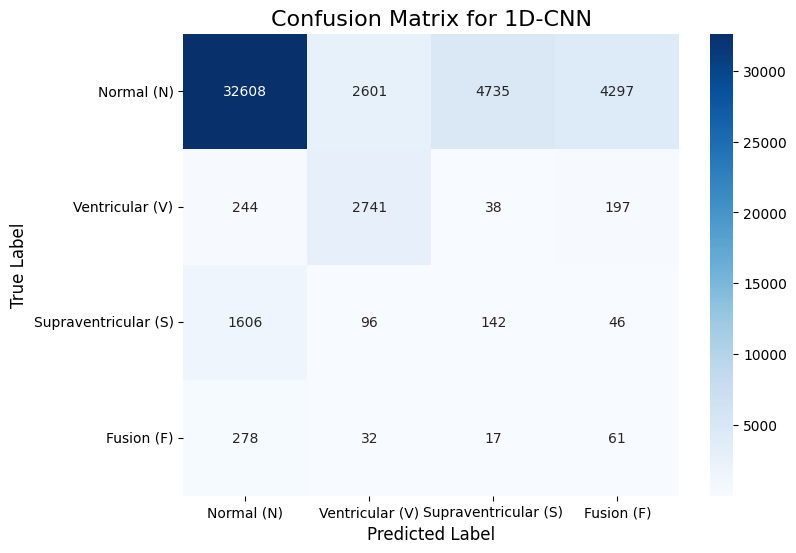


--- Saving model: 1D-CNN ---
✅ Model 1D-CNN has been saved on: ../models/model_1d-cnn_saved.keras


In [11]:
# --- Single-Fold Training for CNN model only--
# Define input and output dimensions for the CNN model
input_shape_cnn = (X_train_cnn.shape[1], X_train_cnn.shape[2])
output_dim = y_train_cnn.shape[1]

# Define the output directory for saving the model
output_dir = '../models'
os.makedirs(output_dir, exist_ok=True)

# --- Manual Class Weights Calculation for the current fold ---
print("Calculating class weights for the current fold...")
n_samples = len(y_train)
class_counts = Counter(y_train)
n_classes = len(class_counts)

manual_weights = {}
print("Manual Calculation Breakdown:")
for i in range(n_classes):
    n_samples_in_class = class_counts.get(i, 0) # Use .get for safety
    weight = n_samples / (n_classes * n_samples_in_class)
    manual_weights[i] = weight
    print(f"  Weight for Class {i} ({class_names[i]}): {n_samples} / ({n_classes} * {n_samples_in_class}) = {weight:.4f}")

class_weights_dict = dict(manual_weights)
print("Fold Weights:", class_weights_dict)

# --- Model Creation ---
print(f"\n{'='*20} CREATING 1D-CNN MODEL {'='*20}")
model = create_cnn_model(input_shape_cnn, output_dim)
model.summary()

# --- Model Training ---
print(f"\n{'='*20} TRAINING 1D-CNN MODEL {'='*20}")
model.fit(
    X_train_cnn, y_train_cnn,
    epochs=150,
    batch_size=100,
    verbose=1,
    validation_data=(X_val_cnn, y_val_cnn),
    class_weight=class_weights_dict
)

# --- Model Evaluation ---
print(f"\n{'='*20} EVALUATING 1D-CNN MODEL {'='*20}")
# Predict on the test set
y_pred_raw = model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_raw, axis=1)
y_true = y_test_final # Use the final, combined ground truth labels

# --- Final Evaluation Report ---
class_names = ['Normal (N)', 'Ventricular (V)', 'Supraventricular (S)', 'Fusion (F)']
print(f"\n{'~'*15} REPORT FOR 1D-CNN MODEL {'~'*15}")

# --- Classification Report ---
print("\nClassification Report:")
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
print(report)

# --- Confusion Matrix Visualization ---
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for 1D-CNN', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

# --- Saving the Model ---
print(f"\n--- Saving model: 1D-CNN ---")
model_path = os.path.join(output_dir, "model_1d-cnn_saved.keras")
# Use model.save() for Keras models for better compatibility
model.save(model_path) 
print(f"✅ Model 1D-CNN has been saved on: {model_path}")